In [1]:
import os 
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

In [2]:
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from coord_conv import CoordConv
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Softmax,MaxPooling2D,UpSampling2D,Input,ActivityRegularization,Dropout,ReLU,Add

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Helper Functions

In [3]:
def create_ran_numbers(img_size):
    '''
    Function to create random coordinates 
    
    @param img_size: Image size 
    
    return:
    random generated x,y coordinates 
    '''
    c1=np.random.randint(img_size, size=1)
    c2=np.random.randint(img_size, size=1)
    c1=tf.convert_to_tensor( c1,dtype=None,dtype_hint=None,name=None)
    c2=tf.convert_to_tensor( c2,dtype=None,dtype_hint=None,name=None)
    return c1,c2

@tf.function
def create_tf_tilecords(coord_list, img_size):
    o1,o2=coord_list
    multiply=tf.constant([img_size*img_size])
    y1=tf.reshape(tf.tile(o1,multiply),[img_size,img_size,1])
    y2=tf.reshape(tf.tile(o2,multiply),[img_size,img_size,1])

    y=tf.concat((y1,y2),axis=2)

    return tf.dtypes.cast(y, tf.float32),tf.dtypes.cast(coord_list, tf.float32)

@tf.function
def tf_create_onehotcords(dat):
    o1,o2=dat
    y1=tf.one_hot(o1,100)
    y2=tf.one_hot(o2,100)
    y2=tf.transpose(y2)
    y=tf.math.multiply(y1,y2)
    #y=tf.transpose(y)
    return y

def create_dat_samples(n):
    '''
    Function to create stacks of coordinates, tiled coordinates, one hot images
    @param n: number of neurons
    '''
    ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    tb = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    coords = tf.TensorArray(tf.float32, size=0, dynamic_size = True)
    for _ in tf.range(n):
        dat=create_ran_numbers(img_size=100)
        b1,b2=create_tf_tilecords(dat, 100)
        c1=tf_create_onehotcords(dat)
        c1=tf.expand_dims(c1, axis=2, name=None)
        
        #tile coordinates
        ta = ta.write(_, b1/99)  #(n, img_size, img_size, 1)
        #one hot images
        tb = tb.write(_, c1) #(n, img_size, img_size, 1)
        #coordinates
        coords = coords.write(_, dat) #(n, 2, 1)
    return coords.stack(), ta.stack(),tb.stack()

def neuron_like_image(n_neurons):
    '''
    Function to paint neuron-like images
     @param n_neurons: number of neurons
    '''
    _,_,one_hot_imgs = create_dat_samples(n_neurons)
    stack_imgs = tf.reduce_sum(one_hot_imgs, axis = 0)
    return tf.expand_dims(stack_imgs, axis = 0) #(1, img_size, img_size, 1)

def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

---

# Build Model

In [4]:
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))

de_coordconv.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 2)]     0         
_________________________________________________________________
coord_conv (CoordConv)       (None, 100, 100, 100)     500       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 50)      5050      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 50)      2550      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 100)     5100      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 100)     10100     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 1)       101   

In [5]:
de_coordconv.load_weights("best_class_model100_02.hdf5")

## Custom Layer

In [6]:
 class learnable_coords(tf.Module):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
#         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y

(1, 100, 100, 1)


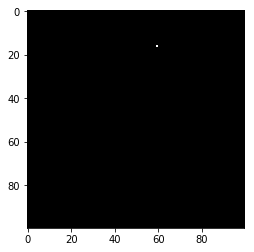

In [7]:
neuron_imgs = neuron_like_image(1)
print(neuron_imgs.shape)
plt.imshow(tf.squeeze(neuron_imgs), cmap='gray')

In [8]:
# img_path = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy'
# neuron_imgs = np.load(img_path).astype(np.float32)
# neuron_imgs = np.reshape(cv2.resize(neuron_imgs[0], (100,100)), (1,100,100,1))
# print(neuron_imgs.shape)
# plt.imshow(np.squeeze(neuron_imgs), cmap='gray')

In [9]:
n_neurons = 1
img_size = 100
coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[1 1 1 2]


In [10]:
lr=0.01
l_coords = learnable_coords(coords)
opt = tf.keras.optimizers.Adam(lr)
loss_fn = tf.losses.MeanSquaredError()

@tf.function
def train_fn(coords, neuron_imgs, img_size, dot = True):
    with tf.GradientTape() as tape:
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        if dot == True:
            similarity_score = tf.tensordot(one_hot_imgs, neuron_imgs, [[1,2,3],[0,1,2]]) #(n_neurons, 1)
        else:
            similarity_score = tf.image.ssim(neuron_imgs, one_hot_imgs, max_val=1.0)
        mul = tf.reshape(similarity_score, [-1,1,1,1])*one_hot_imgs #multiplication
        mul = tf.reduce_sum(mul, axis=0) #(img_size, img_size, 1)
        loss = loss_fn(tf.squeeze(neuron_imgs), tf.squeeze(mul))
        
    gradients = tape.gradient(loss, l_coords.trainable_variables)
    opt.apply_gradients(zip(gradients, l_coords.trainable_variables))
    
    return loss, gradients, updated_coords, one_hot_imgs, similarity_score

---

# Training 

In [11]:
epochs = 0
max_epochs = 1000
one_hot_imgs_list =[]
while epochs <= max_epochs:
    loss, gradients, updated_coords, one_hot_imgs, similarity_score = train_fn(coords, neuron_imgs, img_size, dot=False)
    
    one_hot_imgs_list.append(tf.reduce_sum(one_hot_imgs, axis = 0))
    
    if epochs%100==0:
        print("Epochs {:2d}, Loss: {}".format(epochs, loss.numpy()))
        print("Updated coordinates: {}".format(tf.cast(updated_coords[0]*99, dtype=tf.int32)))
        print("Similarity score: {}".format(similarity_score[0]))
        print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
        print()
    epochs+=1

Epochs  0, Loss: 0.00019657611846923828
Updated coordinates: [[[22  8]]]
Similarity score: 0.9850127100944519
Gradient min:-4.570899818645557e-06, max:5.69820713280933e-06

Epochs 100, Loss: 0.00013092115113977343
Updated coordinates: [[[22  7]]]
Similarity score: 0.9861966967582703
Gradient min:-6.361517534969607e-06, max:9.330626198789105e-06

Epochs 200, Loss: 0.00013091230357531458
Updated coordinates: [[[22  7]]]
Similarity score: 0.9862019419670105
Gradient min:-2.7556448234378195e-09, max:6.736021074260634e-09

Epochs 300, Loss: 0.00013091228902339935
Updated coordinates: [[[22  7]]]
Similarity score: 0.9862019419670105
Gradient min:-1.3287152711427552e-08, max:9.012410373543389e-09

Epochs 400, Loss: 0.00013091228902339935
Updated coordinates: [[[22  7]]]
Similarity score: 0.9862019419670105
Gradient min:-1.3287152711427552e-08, max:9.012410373543389e-09

Epochs 500, Loss: 0.0001309123617829755
Updated coordinates: [[[22  7]]]
Similarity score: 0.9862019419670105
Gradient min:-

# Visualizations

Epochs: 996



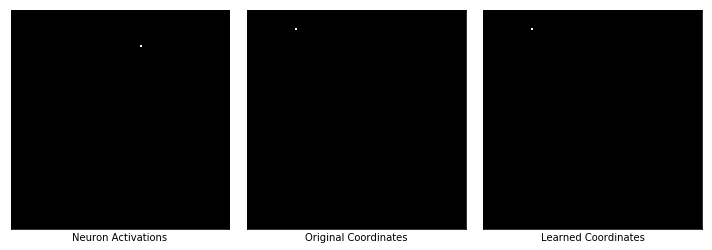

Epochs: 997



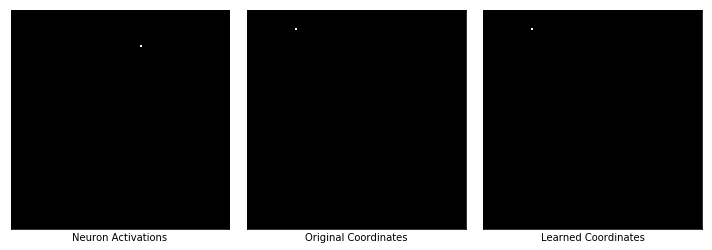

Epochs: 998



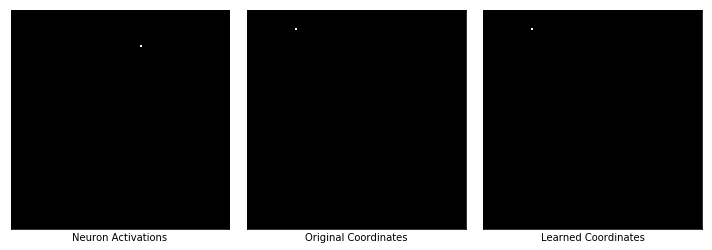

Epochs: 999



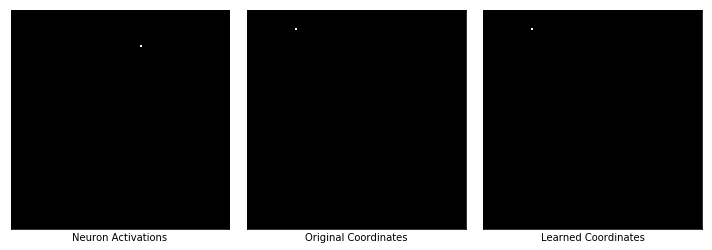

Epochs: 1000



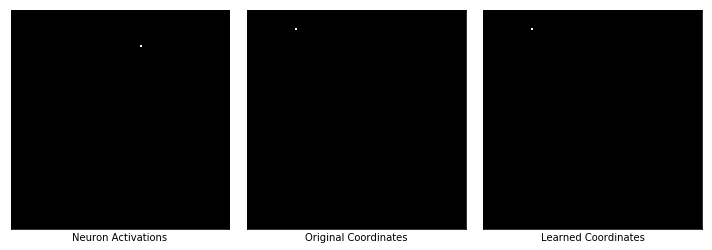

In [12]:
from utils_vis import plot_comparison

captions = ['Neuron Activations', 'Original Coordinates', 'Learned Coordinates']

last_n_images = 5
for i in range(last_n_images):
    index = (len(one_hot_imgs_list)-last_n_images + i)
    print("Epochs: {}".format(index))
    inp_imgs = [neuron_imgs, stack4plot(ori_one_hot_imgs), one_hot_imgs_list[i]]
    plot_comparison(inp_imgs, captions, n_col = 3, figsize = (10,10))